In [1]:
from diffusers import StableDiffusionImageVariationPipeline
import torch
from PIL import Image
# Load the pre-trained model
model_id = "/home/rmuproject/rmuproject/users/sandesh/models/80_epochs"
pipeline = StableDiffusionImageVariationPipeline.from_pretrained(model_id)
device = "cuda" if torch.cuda.is_available() else "cpu"
pipeline.to(device)
pipeline.enable_model_cpu_offload()

/home/rmuproject/rmuproject/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00, 15.45it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_image_variation.StableDiffusionImageVariationPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggi

In [2]:
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
class CustomImageDataset_FeatureExtract(Dataset):
    def __init__(self, dataset, clip_encoder, feature_extractor, size=512):
        """
        Args:
            dataset: A dataset object from the `datasets` library.
            clip_encoder: The CLIP image encoder model (e.g., CLIPVisionModelWithProjection).
            feature_extractor: The feature extractor from the StableDiffusionImageVariationPipeline.
            size: The size to which images should be resized (default: 512x512).
        """
        self.dataset = dataset
        self.clip_encoder = clip_encoder
        self.feature_extractor = feature_extractor
        self.size = size

        # Transformations for the input images (resize, normalize, etc.)
        self.transforms = transforms.Compose(
            [
                transforms.Resize((size, size)),  # Resize to the required size
                transforms.CenterCrop(size),      # Center crop to ensure square images
                transforms.ToTensor(),            # Convert to tensor
                # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),            # Data augmentation
                # transforms.RandomHorizontalFlip(p=0.5),            # Data augmentation
                transforms.Normalize([0.5], [0.5]),  # Normalize to [-1, 1]
            ]
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        example = {}
        try:
            # Load the image
            image = self.dataset[index]["image"]
            if not isinstance(image, Image.Image):
                image = Image.open(image).convert("RGB")  # Ensure it's a PIL image

            if image.mode != "RGB":
                image = image.convert("RGB")

            # Transform the image for the UNet
            example["instance_images"] = self.transforms(image)

            # Generate the CLIP embedding
            with torch.no_grad():
                # Preprocess the image for CLIP using the feature_extractor
                clip_input = self.feature_extractor(image, return_tensors="pt").pixel_values.squeeze(0)  # Shape: [3, 224, 224]
                clip_input = clip_input.to(self.clip_encoder.device)  # Move to the correct device
                example["clip_inputs"] = clip_input
                clip_embedding = self.clip_encoder(clip_input.unsqueeze(0)).image_embeds  # Shape: [1, embedding_dim]
            
            # Add a sequence length dimension to the CLIP embedding
            clip_embedding = clip_embedding.unsqueeze(1).to('cpu')  # Shape: [1, 1, embedding_dim]
            example["clip_embeddings"] = clip_embedding.squeeze(0)  # Remove batch dimension for collation
            
        except Exception as e:
            # Skip corrupted or invalid images
            print(f"Error processing image at index {index}: {e}")
            return self.__getitem__((index + 1) % len(self))  # Skip to the next image

        return example  

In [3]:
import numpy as np
from datasets import load_dataset
from torchvision import transforms
dataset_name = "/home/rmuproject/rmuproject/data/900x1200_4954/Cloud blend 62/12097"  # @param
dataset = load_dataset(dataset_name, split="train")
unet = pipeline.unet
vae = pipeline.vae
clip_encoder = pipeline.image_encoder.to('cpu')
feature_extractor = pipeline.feature_extractor
image_variation_dataset = CustomImageDataset_FeatureExtract(dataset, clip_encoder, feature_extractor)

In [5]:
example = image_variation_dataset[1]
print(example["instance_images"].shape)  # Should be [3, 512, 512]
print(example["clip_embeddings"].shape)  # Should be [embedding_dim]
print(example["clip_inputs"].shape)  # Should be [embedding_dim]
print(example.keys())

torch.Size([3, 512, 512])
torch.Size([1, 768])
torch.Size([3, 224, 224])
dict_keys(['instance_images', 'clip_inputs', 'clip_embeddings'])


CLIP Embedding Shape: torch.Size([1, 768])
Sample CLIP Embedding Values: tensor([[-0.4564,  0.4178,  0.2855, -0.2867,  1.0088, -0.0303,  0.0137,  0.0826,
         -0.8519, -0.5483, -0.6647, -0.2596,  0.0906, -0.6943, -0.5068,  0.0400,
          0.3539, -0.1786,  0.5710, -0.3585]])


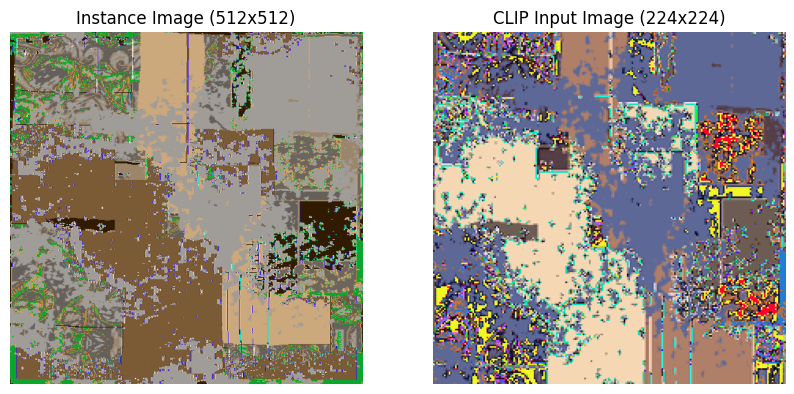

In [6]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Example data
example = image_variation_dataset[1]

# Visualize instance_images (RGB image)
instance_image = example["instance_images"]  # Shape: [3, 512, 512]
instance_image = instance_image.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
instance_image = (instance_image * 255).astype("uint8")  # Scale to [0, 255]
instance_image = Image.fromarray(instance_image)

# Visualize clip_inputs (preprocessed image for CLIP)
clip_input = example["clip_inputs"]  # Shape: [3, 224, 224]
clip_input = clip_input.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
clip_input = (clip_input * 255).astype("uint8")  # Scale to [0, 255]
clip_input = Image.fromarray(clip_input)

# Print clip_embeddings (high-dimensional vector)
clip_embedding = example["clip_embeddings"]  # Shape: [1, 768]
print("CLIP Embedding Shape:", clip_embedding.shape)
print("Sample CLIP Embedding Values:", clip_embedding[:,:20])  # Print first 10 values

# Plot the images
plt.figure(figsize=(10, 5))
# Plot instance_images
plt.subplot(1, 2, 1)
plt.title("Instance Image (512x512)")
plt.imshow(instance_image)
plt.axis("off")
# Plot instance_images
plt.subplot(1, 2, 1)
plt.title("Instance Image (512x512)")
plt.imshow(instance_image)
plt.axis("off")

# Plot clip_inputs
plt.subplot(1, 2, 2)
plt.title("CLIP Input Image (224x224)")
plt.imshow(clip_input)
plt.axis("off")

plt.show()

In [7]:
import torch

# Assuming `vae` is the VAE model from your pipeline
# Move the VAE to the GPU if available
vae = pipeline.vae.to(device)

# Get the instance image from the example
instance_image = example["instance_images"]  # Shape: [3, 512, 512]

# Add a batch dimension and move to the GPU
instance_image = instance_image.unsqueeze(0).to(device)  # Shape: [1, 3, 512, 512]

# Encode the image to get the latents
with torch.no_grad():
    latents = vae.encode(instance_image).latent_dist.sample()  # Shape: [1, 4, 64, 64]

# Check the shape of the latents
print("Latents shape:", latents.shape)  # Should be [1, 4, 64, 64]

Latents shape: torch.Size([1, 4, 64, 64])


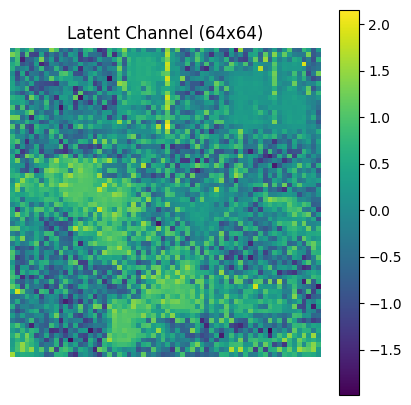

In [10]:
import matplotlib.pyplot as plt

# Select one channel from the latents
latent_channel = latents[0, 0].cpu().numpy()  # Shape: [64, 64]

# Plot the latent channel
plt.figure(figsize=(5, 5))
plt.imshow(latent_channel, cmap="viridis")
plt.title("Latent Channel (64x64)")
plt.colorbar()
plt.axis("off")

plt.show()

In [27]:
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(
        beta_start=0.00085,
        beta_end=0.012,
        beta_schedule="scaled_linear",
        num_train_timesteps=1000,
    )
noise = torch.randn(latents.shape).to(latents.device)

bsz = latents.shape[0]

# Sample a random timestep for each image
timesteps = torch.randint(
    0,
    noise_scheduler.config.num_train_timesteps,
    (bsz,),
    device=latents.device,
).long()
print(timesteps)

tensor([825], device='cuda:0')


In [28]:
noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

In [29]:
print(noisy_latents.shape)

torch.Size([1, 4, 64, 64])


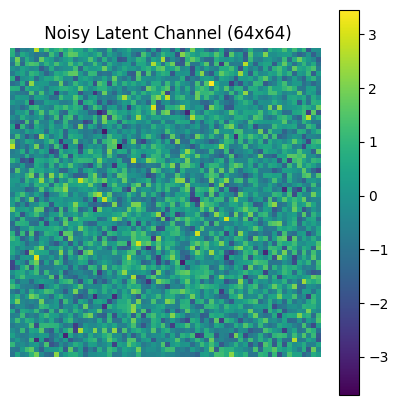

In [30]:
import matplotlib.pyplot as plt

# Select one channel from the latents
noisy_latent_channel = noisy_latents[0, 0].cpu().numpy()  # Shape: [64, 64]

# Plot the latent channel
plt.figure(figsize=(5, 5))
plt.imshow(noisy_latent_channel, cmap="viridis")
plt.title(" Noisy Latent Channel (64x64)")
plt.colorbar()
plt.axis("off")

plt.show()

In [32]:
import torch.nn.functional as F
clip_embeddings = clip_embedding.unsqueeze(0).to(device)  # Shape: [1, 3, 512, 512]

noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states=clip_embeddings).sample

# Calculate the loss
loss = F.mse_loss(noise_pred, noise, reduction="none").mean([1, 2, 3]).mean()

tensor(0.0103, device='cuda:0', grad_fn=<MeanBackward0>)


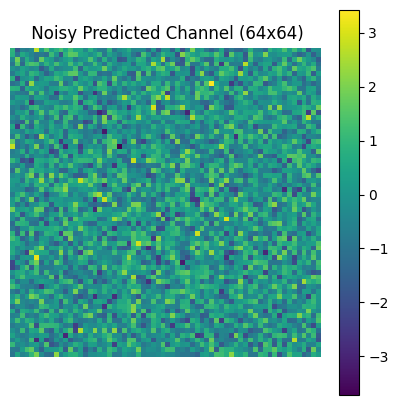

In [35]:
print(loss)
import matplotlib.pyplot as plt

# Select one channel from the latents
noisy_predicted_channel = noise_pred[0, 0].detach().cpu().numpy()  # Shape: [64, 64]

# Plot the latent channel
plt.figure(figsize=(5, 5))
plt.imshow(noisy_predicted_channel, cmap="viridis")
plt.title(" Noisy Predicted Channel (64x64)")
plt.colorbar()
plt.axis("off")

plt.show()